In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chaosmagpy.model_utils import design_gauss, power_spectrum
from chaosmagpy.data_utils import timestamp
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from alberte_klara_lib import do_design, plot_map_three, plot_map_one, do_design_timetrend, get_gausscoeff_timetrend, plot_difference_F, plot_power_spectrum, plot_hist_withzoom
from alberte_klara_lib import n_int_max, n_ext_max, theta_grid, phi_grid, radius_Earth, radius_CMB
import os

In [38]:
# data_dst = 'ready_oersted_data\oersted_dark_quiet_2000.txt'
data_dst = 'ready_oersted_data\oersted_dark_quiet_2001.txt'
data = pd.read_table(data_dst, delimiter = ",")
data

<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
C:\Users\klara\AppData\Local\Temp\ipykernel_24644\3691718124.py:2: SyntaxWarning: invalid escape sequence '\o'
  data_dst = 'ready_oersted_data\oersted_dark_quiet_2001.txt'


time_stamp    radius     colat       lon       B_r   B_theta    B_phi  \
0       366.045415  7169.562   61.2410   42.7035 -20018.21 -21715.57   696.16   
1       366.046151  7175.330   57.4999   41.8649 -22794.86 -20488.69   812.18   
2       366.046886  7180.887   53.7676   40.9776 -25260.73 -19174.04   912.91   
3       366.047622  7186.213   50.0451   40.0291 -27438.83 -17798.54   994.82   
4       366.048358  7191.287   46.3326   39.0029 -29335.48 -16411.96  1058.68   
...            ...       ...       ...       ...       ...       ...      ...   
143775  730.733706  7228.155   84.4774   75.9805   2509.46 -25574.19 -1520.66   
143776  730.736228  7229.999   71.8301   73.5638 -11002.06 -25053.55  -566.51   
143777  730.737555  7228.780   65.1825   72.2108 -17519.28 -23573.17  -112.41   
143778  730.793067  7173.312  134.6450   61.6734  28610.35  -8939.13 -8330.00   
143779  732.461516  7215.079  109.5852  176.5336  20308.99 -21288.59  4750.69   

               X        Y         Z      dDst      Hp30             F  \
0       21715.57   696.16  20018.21  3.380095  0.333000  29542.839247   
1       20488.69   812.18  22794.86  3.062324  0.333000  30660.262502   
2       19174.04   912.91  25260.73  2.744549  0.333000  31726.671662   
3       17798.54   994.82  27438.83  2.426786  0.333000  32721.049566   
4       16411.96  1058.68  29335.48  2.109015  0.333000  33630.991975   
...          ...      ...       ...       ...       ...           ...   
143775  25574.19 -1520.66  -2509.46  2.762251  3.072564  25741.969437   
143776  25053.55  -566.51  11002.06  3.186011  3.112876  27368.716182   
143777  23573.17  -112.41  17519.28  3.408922  3.134081  29370.600123   
143778   8939.13 -8330.00 -28610.35  1.529097  3.400197  31110.272777   
143779  21288.59  4750.69 -20308.99  1.729011  2.667000  29803.157458   

        B_radius  
0      -20018.21  
1      -22794.86  
2      -25260.73  
3      -27438.83  
4      -29335.48  
...          ...  
143775   2509.46  
143776 -11002.06  
143777 -17519.28  
143778  28610.35  
143779  20308.99  

[143780 rows x 14 columns]

In [44]:
nm_static = (n_int_max + 1)**2 - 1 + (n_ext_max + 1)**2 - 1
n_obs = len(data)

# lhs and rhs of lst sq prb will have to be constructed bit by bit
# allocating these in memory
lhs = np.zeros((nm_static, nm_static)) # G.T@G
rhs = np.zeros((nm_static,)) # G.T@d

# taking 10k data point at a time (sub matrix, chunk of data, G_sub) - but still all model parameters
i = 0
while (i <= n_obs - 10*10**3):
    i10k = i + 10*10**3

    G_int = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_int_max)))
    print(G_int.shape)
    G_ext = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_ext_max, source = 'external')))
    G = np.hstack((G_int, G_ext))
    lhs += G.T@G

    d = np.hstack((data['B_radius'].iloc[i:i10k], data['B_theta'].iloc[i:i10k], data['B_phi'].iloc[i:i10k]))
    rhs += G.T@d
    i += 10*10**3

G_int = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_int_max)))
G_ext = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_ext_max, source = 'external')))
G = np.hstack((G_int, G_ext))
lhs += G.T@G

d = np.hstack((data['B_radius'].iloc[i:], data['B_theta'].iloc[i:], data['B_phi'].iloc[i:]))
rhs += G.T@d


m = np.linalg.solve(lhs, rhs)

m_int_static = m[:-((n_ext_max + 1)**2 - 1)]
m_ext_static = m[-((n_ext_max + 1)**2 - 1):]

np.savetxt(os.path.join('ready_oersted_data', 'int_model_static_parameters'), m_int_static)
np.savetxt(os.path.join('ready_oersted_data', 'ext_model_static_parameters'), m_ext_static)

(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)


In [45]:
# Predicted field at Swarm altitude
G_pred_static_radius, G_pred_static_theta, G_pred_static_phi = do_design(data['radius'], data['colat'], data['lon'], n_int_max, n_ext_max)

b_pred_static_radius = G_pred_static_radius @ m
b_pred_static_theta = G_pred_static_theta @ m
b_pred_static_phi = G_pred_static_phi @ m

# field intensity
F_pred_static = np.sqrt(b_pred_static_radius**2 + b_pred_static_theta**2 + b_pred_static_phi**2)


# Residuals between model-predicted field and measured field

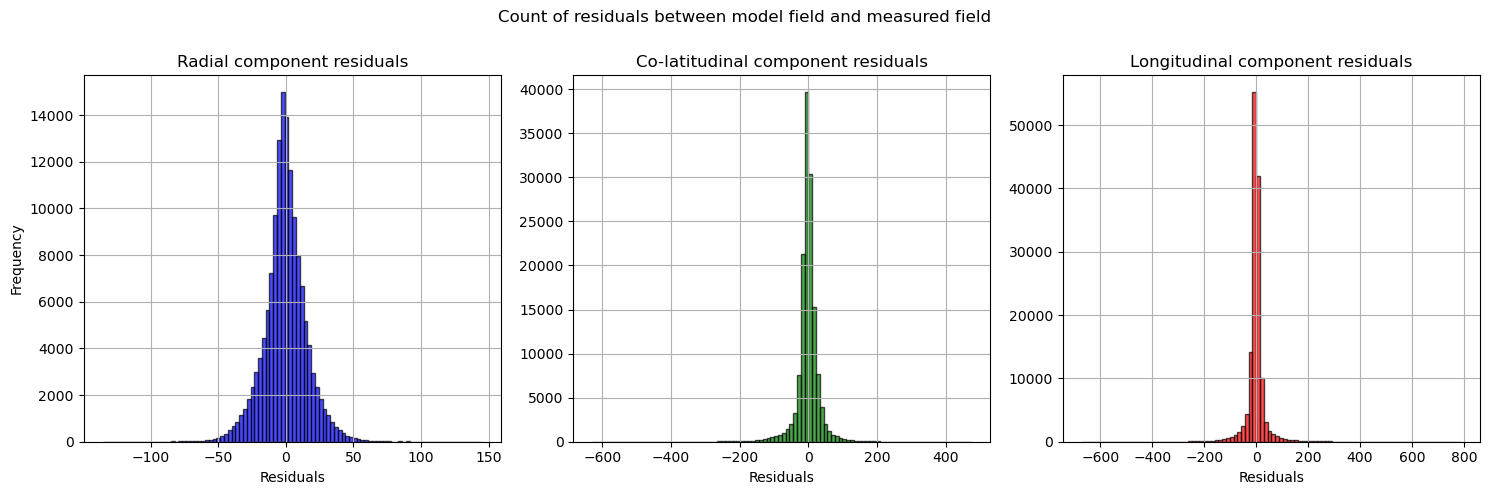

In [46]:
# Residuals
residuals_r_static = data['B_radius'] - b_pred_static_radius
residuals_t_static = data['B_theta'] - b_pred_static_theta
residuals_p_static = data['B_phi'] - b_pred_static_phi


# Plot histogram of residuals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram of residuals_r
axs[0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Radial component residuals')
axs[0].grid(True)

# Plot histogram of residuals_t
axs[1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Residuals')
# axs[1].set_ylabel('Frequency')
axs[1].set_title('Co-latitudinal component residuals')
axs[1].grid(True)

# Plot histogram of residuals_p
axs[2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_xlabel('Residuals')
# axs[2].set_ylabel('Frequency')
axs[2].set_title('Longitudinal component residuals')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Count of residuals between model field and measured field')

plt.show()

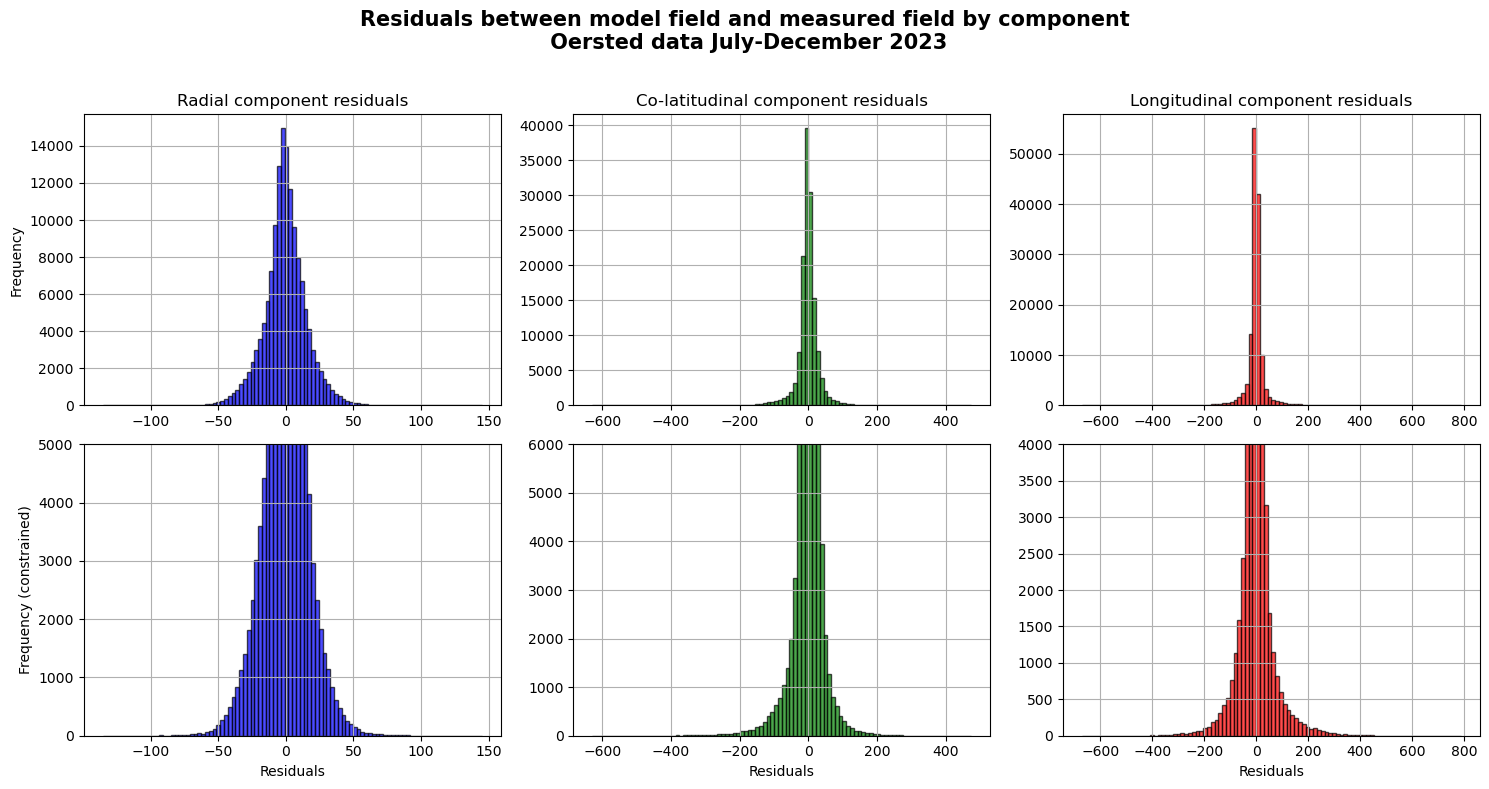

In [47]:
# Plot histogram of residuals
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Plot histogram of residuals_r
axs[0, 0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Radial component residuals')
axs[0, 0].grid(True)

# Plot histogram of residuals_t
axs[0, 1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[0, 1].set_title('Co-latitudinal component residuals')
axs[0, 1].grid(True)

# Plot histogram of residuals_p
axs[0, 2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[0, 2].set_title('Longitudinal component residuals')
axs[0, 2].grid(True)

# Plot histogram of residuals_r (constrained)
axs[1, 0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_ylabel('Frequency (constrained)')
axs[1, 0].set_ylim(0, 5000)
axs[1, 0].grid(True)

# Plot histogram of residuals_t (constrained)
axs[1, 1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1, 1].set_xlabel('Residuals')
axs[1, 1].set_ylim(0, 6000)
axs[1, 1].grid(True)

# Plot histogram of residuals_p (constrained)
axs[1, 2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[1, 2].set_xlabel('Residuals')
axs[1, 2].set_ylim(0, 4000)
axs[1, 2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Residuals between model field and measured field by component\n Oersted data July-December 2023', weight = 'bold', fontsize = 15)

plt.show()

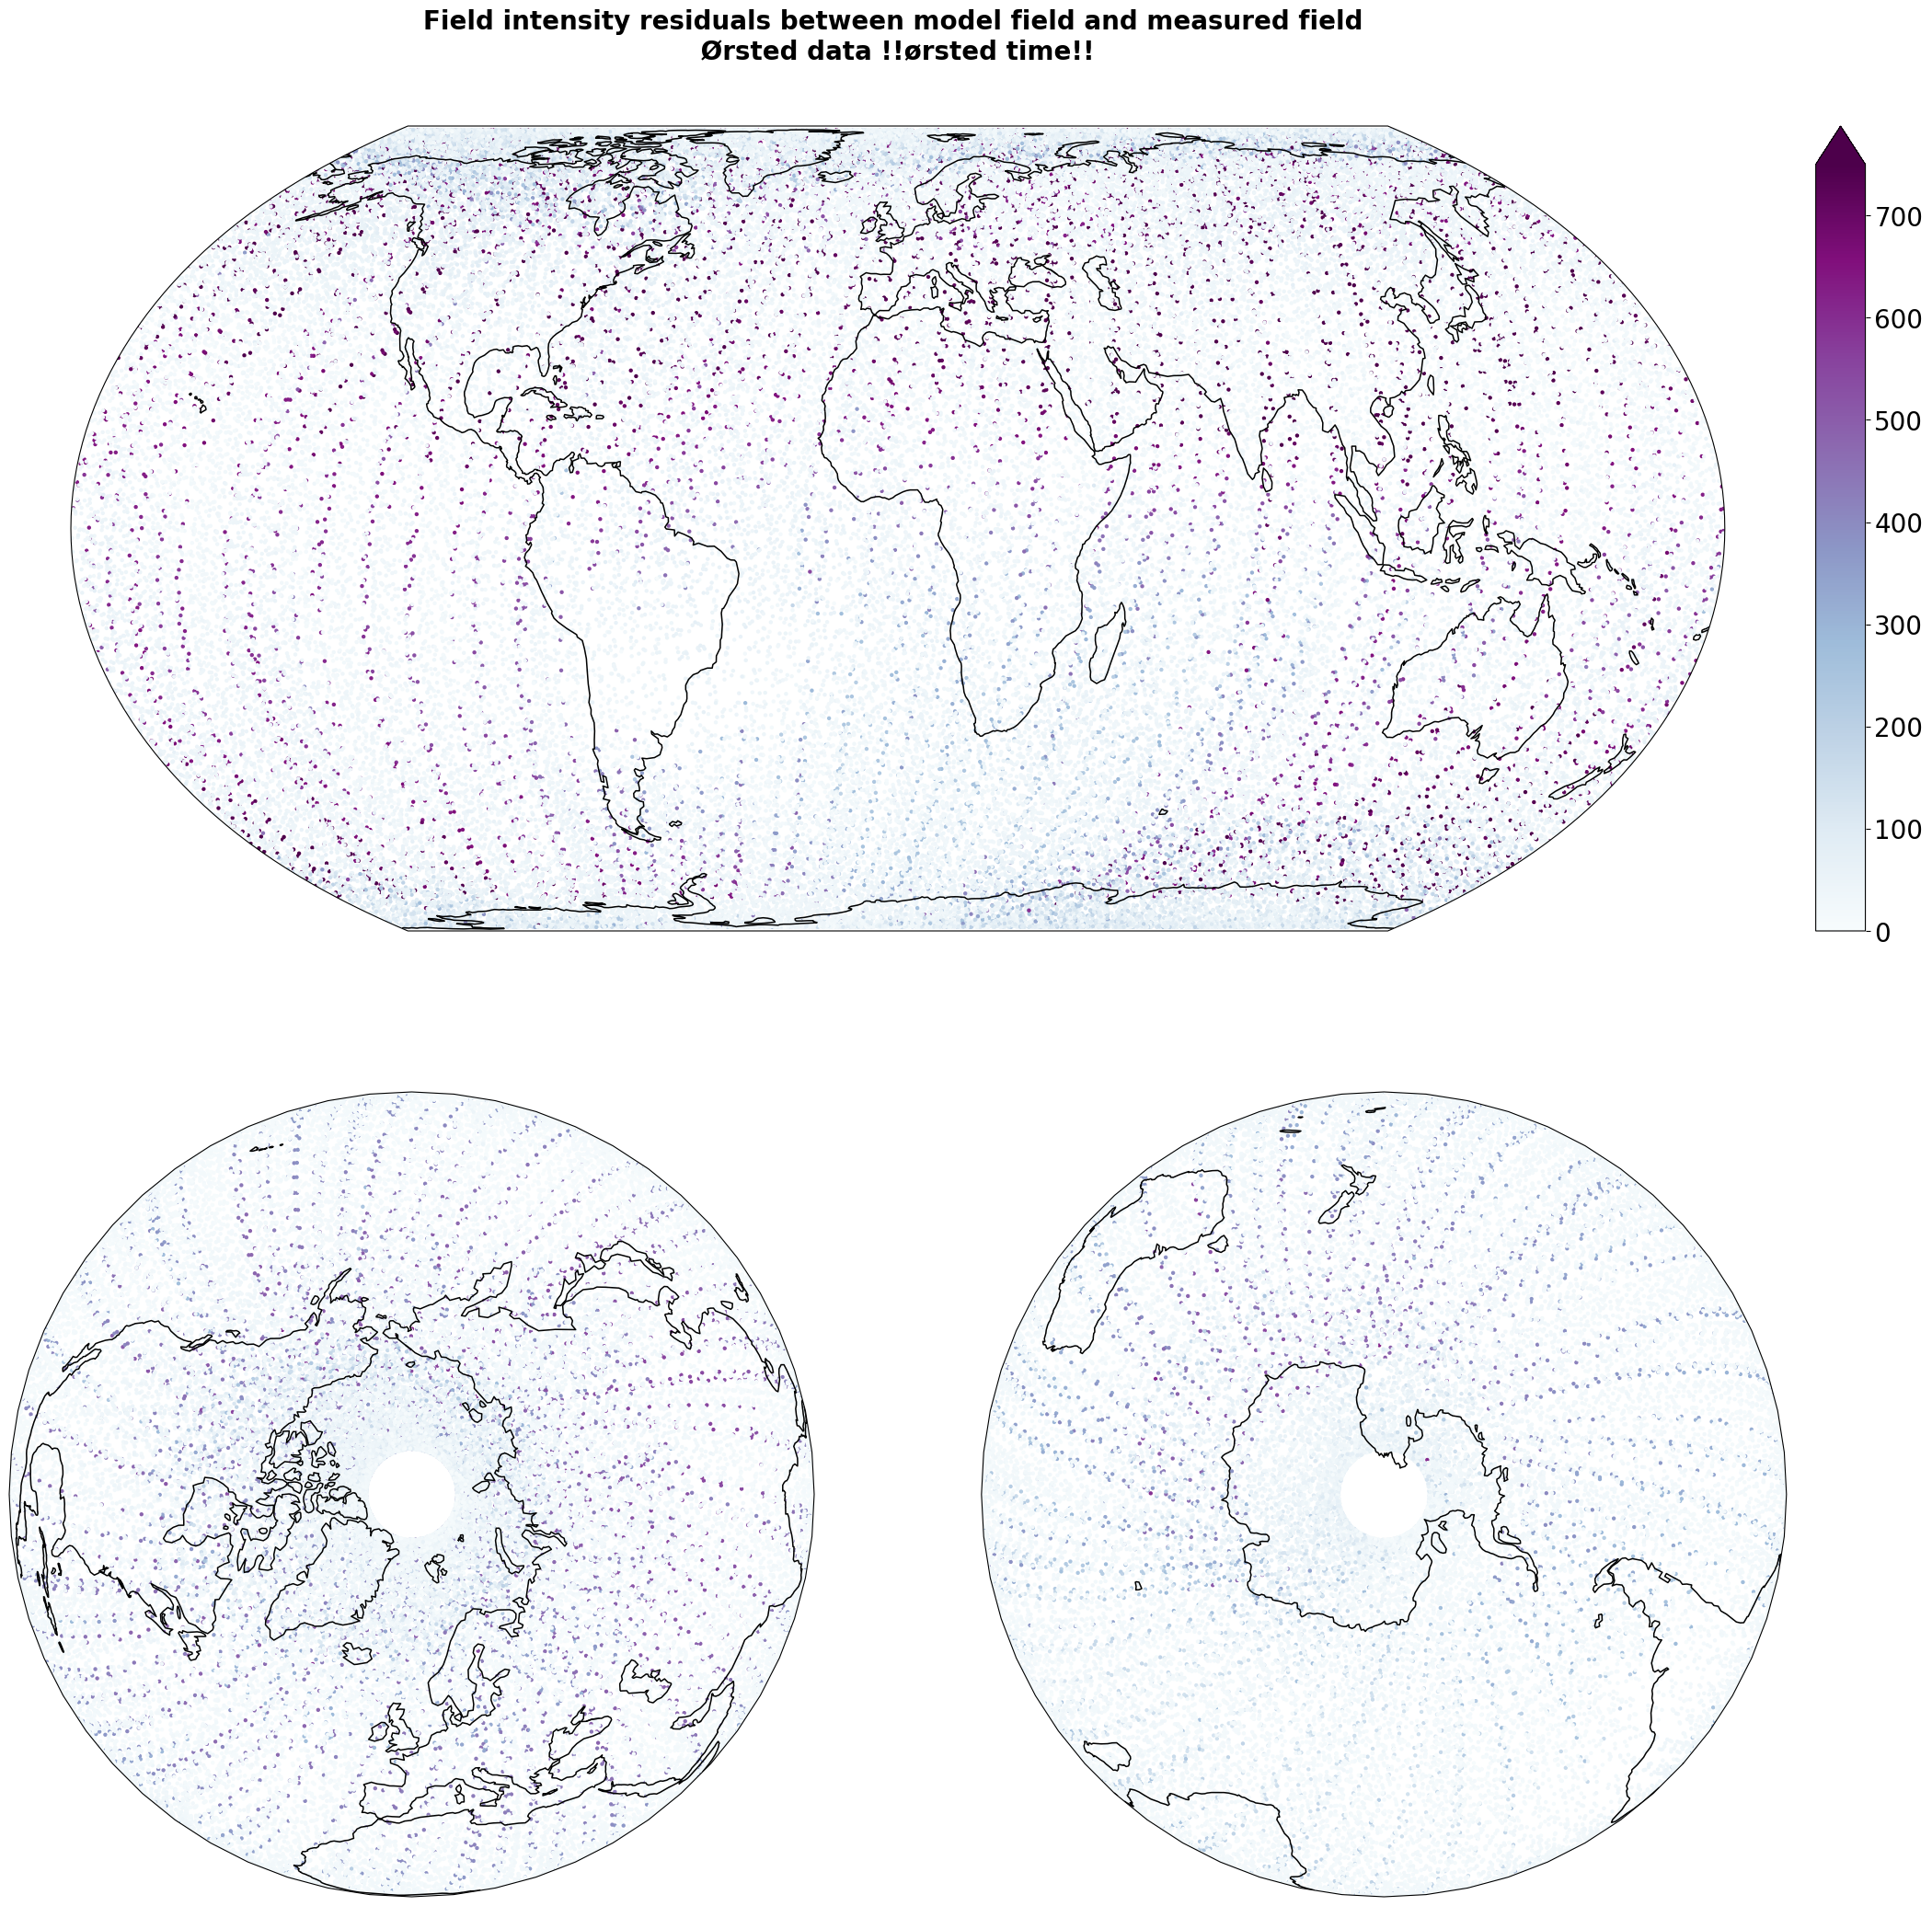

In [7]:
# Intensity of residuals on map
F_residuals = np.sqrt(residuals_r_static**2 + residuals_t_static**2 + residuals_p_static**2)

plot_map_three(F_residuals, data['lon'], data['colat'], 'Oersted', 'Field intensity residuals between model field and measured field', 'Residuals [nT]', scatter_size = 10, clim=[0, 750], colors='BuPu')

# Model with temporal gradient - linear trend of secular variation


In [39]:
# t0 = t_start + (t_end - t_start)/2
t0_exact = min(data['time_stamp'].values) + (max(data['time_stamp'].values) - min(data['time_stamp'].values))/2

# must manipulate with time stamp because data points have been removed
t = np.floor(round(data['time_stamp'], 2)*10)/10

t0_idx = np.argmin(np.abs(t - t0_exact))
t0 = data['time_stamp'].iloc[t0_idx]
print("\nt0 = " + str(t0) + " at index " + str(t0_idx) + "\ndate in np datetime64 format: " + str(timestamp(t0)))

# temporal gradient
data['time_grad'] = data['time_stamp'] - t0

# np.savetxt(os.path.join('ready_swarm_data', 'time_grad_frame'), [data['time_grad'].iloc[0], data['time_grad'].iloc[-1]])



t0 = 549.29536426 at index 73451
date in np datetime64 format: 2001-07-03T07:05:19.472064


In [40]:
m = get_gausscoeff_timetrend(data, n_int_max, n_ext_max)

In [41]:
# # Predicted field at measurement coordinates
G_pred_radius1, G_pred_theta1, G_pred_phi1 = do_design_timetrend(data['radius'], data['colat'], data['lon'], n_int_max, n_ext_max, data['time_grad'].values)

b_pred_radius1 = G_pred_radius1 @ m
b_pred_theta1 = G_pred_theta1 @ m
b_pred_phi1 = G_pred_phi1 @ m

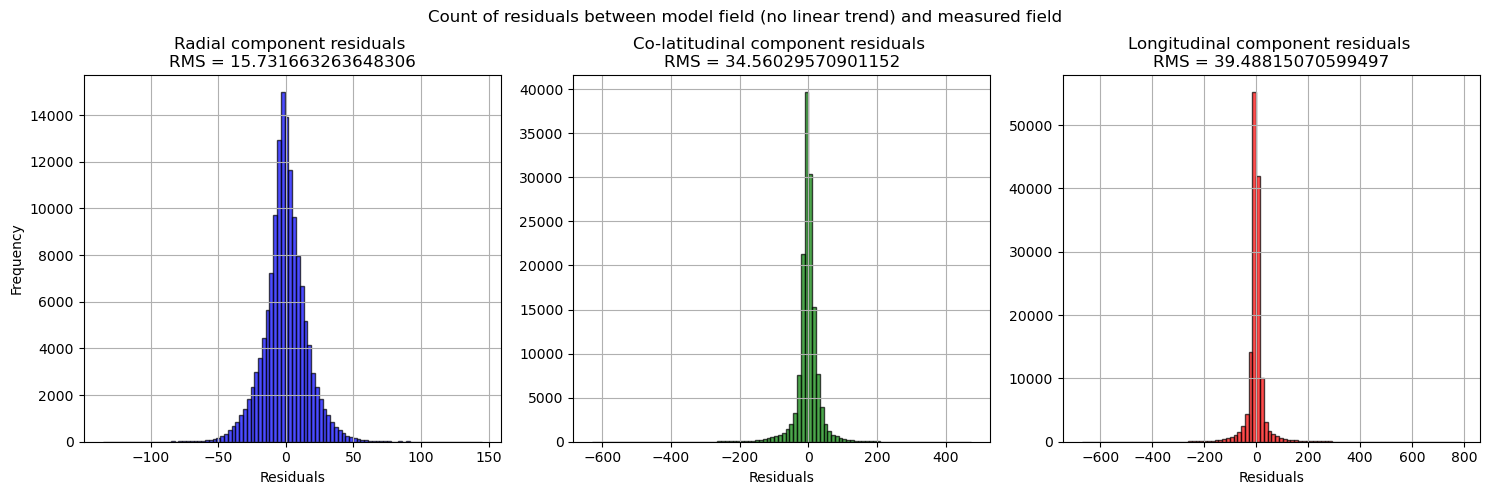

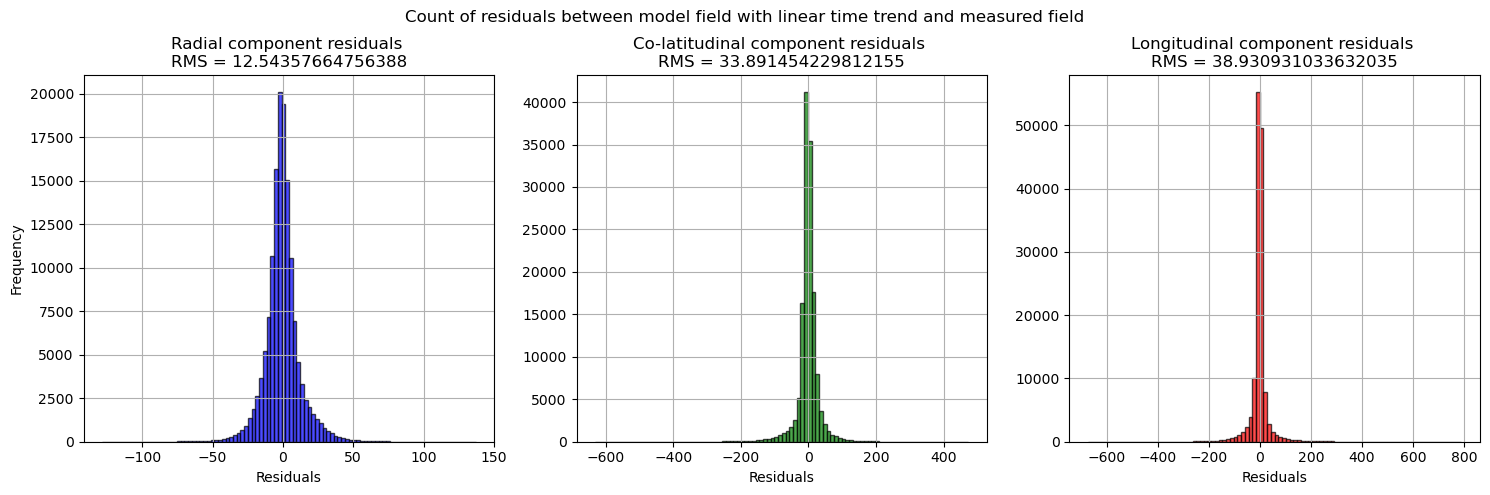

In [48]:
residuals_r1 = data['B_radius'] - b_pred_radius1
residuals_t1 = data['B_theta'] - b_pred_theta1
residuals_p1 = data['B_phi'] - b_pred_phi1


# Plot histogram of residuals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram of residuals_r
axs[0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Radial component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_r_static**2))))
axs[0].grid(True)

# Plot histogram of residuals_t
axs[1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Residuals')
axs[1].set_title('Co-latitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_t_static**2))))
axs[1].grid(True)

# Plot histogram of residuals_p
axs[2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_xlabel('Residuals')
axs[2].set_title('Longitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_p_static**2))))
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Count of residuals between model field (no linear trend) and measured field')

plt.show()


# Plot histogram of residuals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram of residuals_r
axs[0].hist(residuals_r1, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Radial component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_r1**2))))
axs[0].grid(True)

# Plot histogram of residuals_t
axs[1].hist(residuals_t1, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Residuals')
axs[1].set_title('Co-latitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_t1**2))))
axs[1].grid(True)

# Plot histogram of residuals_p
axs[2].hist(residuals_p1, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_xlabel('Residuals')
axs[2].set_title('Longitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_p1**2))))
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Count of residuals between model field with linear time trend and measured field')

plt.show()

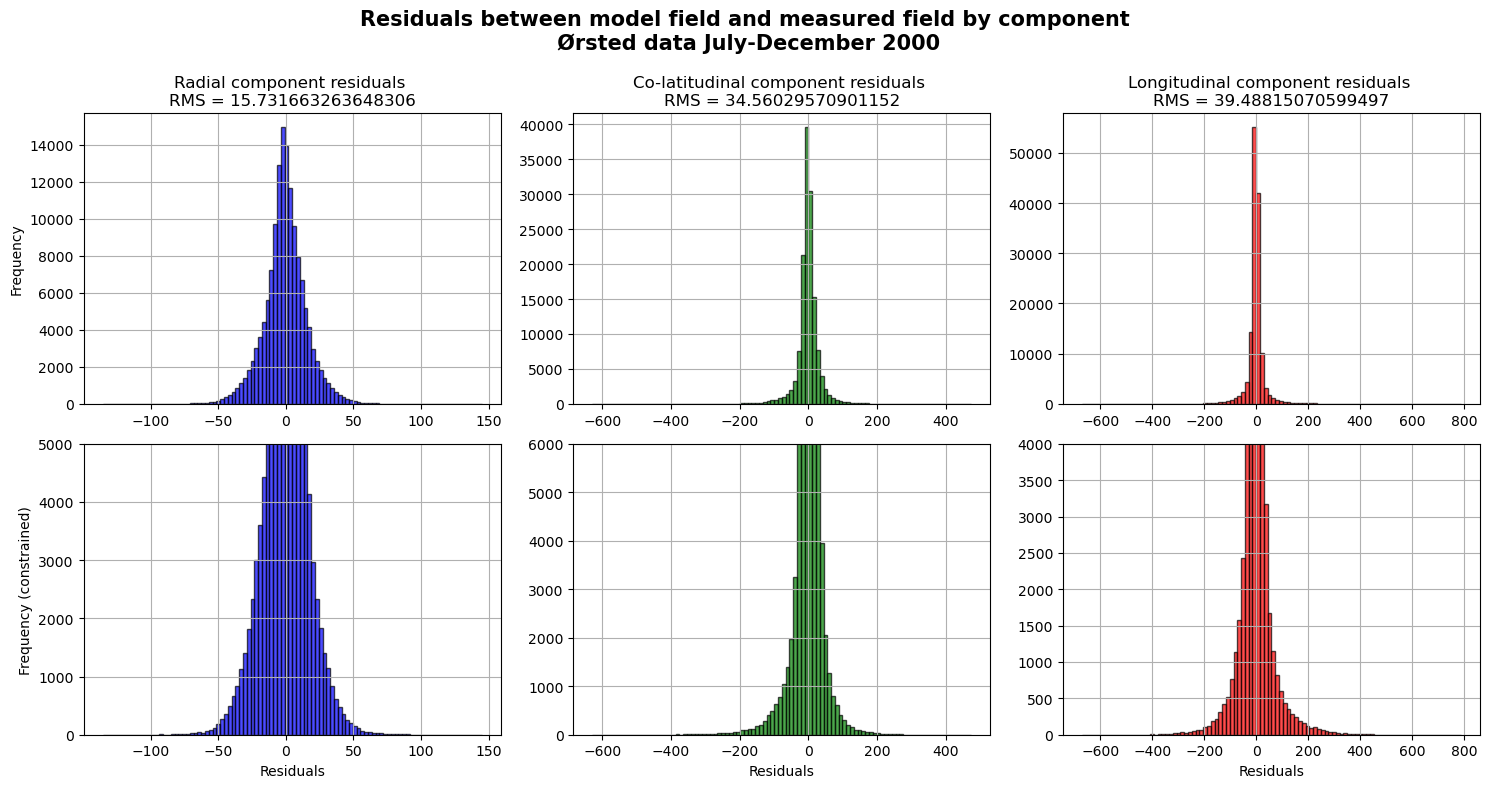

In [58]:
plot_hist_withzoom(residuals_r_static, residuals_t_static, residuals_p_static, 5000, 6000, 4000, sat = 'ørsted')

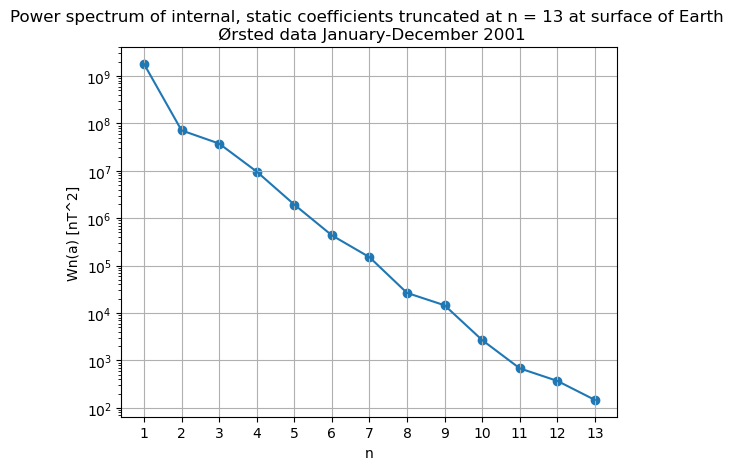

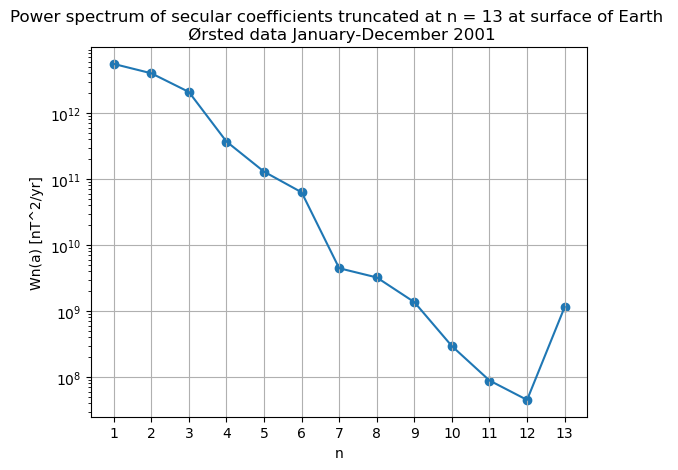

In [62]:
plot_power_spectrum(m, n_int_max, radius_Earth, sat = 'ørsted')
plot_power_spectrum(m, n_int_max, radius_Earth, static=False, sat = 'ørsted')